In [1]:
from neuralop.datasets.darcy import load_darcy_flow_small

In [2]:
train_loader, test_loaders, output_encoder = load_darcy_flow_small(
    n_train=100, batch_size=4,
    test_resolutions=[16, 32], n_tests=[50, 50], test_batch_sizes=[4, 2],
)

UnitGaussianNormalizer init on 100, reducing over [0, 1, 2, 3], samples of shape [1, 16, 16].
   Mean and std of shape [1, 1, 1], eps=1e-05
Loading test db at resolution 32 with 50 samples and batch-size=2


In [3]:
train_dataset = train_loader.dataset

In [4]:
for res, test_loader in test_loaders.items():
    print('res: ', res)
    test_data = train_dataset[0]
    x = test_data['x']
    y = test_data['y']

    print(f'Testing samples for res {res} have shape {x.shape[1:]}')

res:  16
Testing samples for res 16 have shape [16, 16]
res:  32
Testing samples for res 32 have shape [16, 16]


Training sample have shape [16, 16]


C:\Users\kinet\AppData\Local\Temp\ipykernel_18736\627108680.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


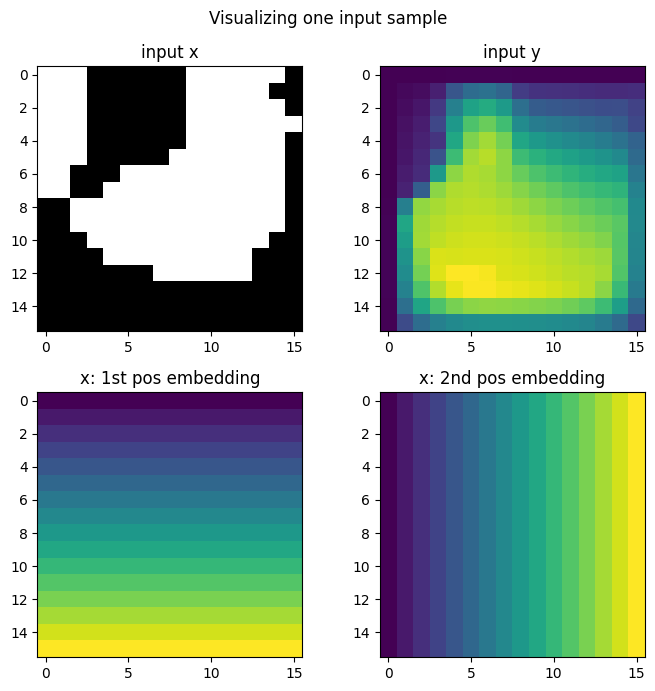

In [5]:
import matplotlib.pyplot as plt
data = train_dataset[0]
x = data['x'] # [3, 16, 16]
y = data['y'] # [1, 16, 16]

print(f'Training sample have shape {x.shape[1:]}')


# Which sample to view
index = 0

data = train_dataset[index]
x = data['x']
y = data['y']
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(2, 2, 1)
ax.imshow(x[0], cmap='gray')
ax.set_title('input x')
ax = fig.add_subplot(2, 2, 2)
ax.imshow(y.squeeze())
ax.set_title('input y')
ax = fig.add_subplot(2, 2, 3)
ax.imshow(x[1])
ax.set_title('x: 1st pos embedding')
ax = fig.add_subplot(2, 2, 4)
ax.imshow(x[2])
ax.set_title('x: 2nd pos embedding')
fig.suptitle('Visualizing one input sample', y=0.98)
plt.tight_layout()
fig.show()

In [6]:
import paddle
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss

In [8]:
model = TFNO(n_modes=(16, 16), hidden_channels=32, projection_channels=64)

n_params = count_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has Tensor(shape=[1], dtype=int64, place=Place(gpu:0), stop_gradient=True,
       [1051137]) parameters.


In [9]:
model

TFNO(
  (convs): FactorizedSpectralConv(
    (weight): LayerList(
      (0): FactorizedTensor(shape=(32, 32, 8, 8))
      (1): FactorizedTensor(shape=(32, 32, 8, 8))
      (2): FactorizedTensor(shape=(32, 32, 8, 8))
      (3): FactorizedTensor(shape=(32, 32, 8, 8))
      (4): FactorizedTensor(shape=(32, 32, 8, 8))
      (5): FactorizedTensor(shape=(32, 32, 8, 8))
      (6): FactorizedTensor(shape=(32, 32, 8, 8))
      (7): FactorizedTensor(shape=(32, 32, 8, 8))
    )
  )
  (fno_skips): LayerList(
    (0): SoftGating()
    (1): SoftGating()
    (2): SoftGating()
    (3): SoftGating()
  )
  (lifting): Lifting(
    (fc): Conv2D(3, 32, kernel_size=[1, 1], data_format=NCHW)
  )
  (projection): Projection(
    (fc1): Conv2D(32, 64, kernel_size=[1, 1], data_format=NCHW)
    (fc2): Conv2D(64, 1, kernel_size=[1, 1], data_format=NCHW)
  )
)

In [ ]:
optimizer = paddle.optimizer.Adam(learning_rate=1e-3, parameters=model.parameters())

## loading the pt weight layer by layer

In [13]:
import torch

weights = torch.load('model_trained.pt', map_location=torch.device('cpu'))

In [14]:
list(weights.keys())

['convs.bias',
 'convs.weight.0.tensor',
 'convs.weight.1.tensor',
 'convs.weight.2.tensor',
 'convs.weight.3.tensor',
 'convs.weight.4.tensor',
 'convs.weight.5.tensor',
 'convs.weight.6.tensor',
 'convs.weight.7.tensor',
 'fno_skips.0.weight',
 'fno_skips.1.weight',
 'fno_skips.2.weight',
 'fno_skips.3.weight',
 'lifting.fc.weight',
 'lifting.fc.bias',
 'projection.fc1.weight',
 'projection.fc1.bias',
 'projection.fc2.weight',
 'projection.fc2.bias']

In [15]:
model

TFNO(
  (convs): FactorizedSpectralConv(
    (weight): LayerList(
      (0): FactorizedTensor(shape=(32, 32, 8, 8))
      (1): FactorizedTensor(shape=(32, 32, 8, 8))
      (2): FactorizedTensor(shape=(32, 32, 8, 8))
      (3): FactorizedTensor(shape=(32, 32, 8, 8))
      (4): FactorizedTensor(shape=(32, 32, 8, 8))
      (5): FactorizedTensor(shape=(32, 32, 8, 8))
      (6): FactorizedTensor(shape=(32, 32, 8, 8))
      (7): FactorizedTensor(shape=(32, 32, 8, 8))
    )
  )
  (fno_skips): LayerList(
    (0): SoftGating()
    (1): SoftGating()
    (2): SoftGating()
    (3): SoftGating()
  )
  (lifting): Lifting(
    (fc): Conv2D(3, 32, kernel_size=[1, 1], data_format=NCHW)
  )
  (projection): Projection(
    (fc1): Conv2D(32, 64, kernel_size=[1, 1], data_format=NCHW)
    (fc2): Conv2D(64, 1, kernel_size=[1, 1], data_format=NCHW)
  )
)

In [16]:
for k, v in weights.items():
    print(k, v.shape)

convs.bias torch.Size([4, 32, 1, 1])
convs.weight.0.tensor torch.Size([32, 32, 8, 8, 2])
convs.weight.1.tensor torch.Size([32, 32, 8, 8, 2])
convs.weight.2.tensor torch.Size([32, 32, 8, 8, 2])
convs.weight.3.tensor torch.Size([32, 32, 8, 8, 2])
convs.weight.4.tensor torch.Size([32, 32, 8, 8, 2])
convs.weight.5.tensor torch.Size([32, 32, 8, 8, 2])
convs.weight.6.tensor torch.Size([32, 32, 8, 8, 2])
convs.weight.7.tensor torch.Size([32, 32, 8, 8, 2])
fno_skips.0.weight torch.Size([1, 32, 1, 1])
fno_skips.1.weight torch.Size([1, 32, 1, 1])
fno_skips.2.weight torch.Size([1, 32, 1, 1])
fno_skips.3.weight torch.Size([1, 32, 1, 1])
lifting.fc.weight torch.Size([32, 3, 1, 1])
lifting.fc.bias torch.Size([32])
projection.fc1.weight torch.Size([64, 32, 1, 1])
projection.fc1.bias torch.Size([64])
projection.fc2.weight torch.Size([1, 64, 1, 1])
projection.fc2.bias torch.Size([1])


In [17]:
# print the same for the model
for k, v in model.state_dict().items():
    print(k, v.shape)

convs.bias [4, 32, 1, 1]
convs.weight.0.real [32, 32, 8, 8]
convs.weight.0.imag [32, 32, 8, 8]
convs.weight.1.real [32, 32, 8, 8]
convs.weight.1.imag [32, 32, 8, 8]
convs.weight.2.real [32, 32, 8, 8]
convs.weight.2.imag [32, 32, 8, 8]
convs.weight.3.real [32, 32, 8, 8]
convs.weight.3.imag [32, 32, 8, 8]
convs.weight.4.real [32, 32, 8, 8]
convs.weight.4.imag [32, 32, 8, 8]
convs.weight.5.real [32, 32, 8, 8]
convs.weight.5.imag [32, 32, 8, 8]
convs.weight.6.real [32, 32, 8, 8]
convs.weight.6.imag [32, 32, 8, 8]
convs.weight.7.real [32, 32, 8, 8]
convs.weight.7.imag [32, 32, 8, 8]
fno_skips.0.weight [1, 32, 1, 1]
fno_skips.1.weight [1, 32, 1, 1]
fno_skips.2.weight [1, 32, 1, 1]
fno_skips.3.weight [1, 32, 1, 1]
lifting.fc.weight [32, 3, 1, 1]
lifting.fc.bias [32]
projection.fc1.weight [64, 32, 1, 1]
projection.fc1.bias [64]
projection.fc2.weight [1, 64, 1, 1]
projection.fc2.bias [1]


In [21]:
direct_copy_weights = ["convs.bias", "fno_skips.0.weight", "fno_skips.1.weight", "fno_skips.2.weight", "fno_skips.3.weight", "lifting.fc.weight", "lifting.fc.bias", "projection.fc1.weight", "projection.fc1.bias", "projection.fc2.weight", "projection.fc2.bias"]

for k in direct_copy_weights:
    model.state_dict()[k].set_value(paddle.to_tensor(weights[k].numpy()))

In [22]:
# for layers starting with convs.weight.*, the pytorch is called convs.weight.*.tensor, the paddle is called convs.weight.*.real and convs.weight.*.imag
# put the convs.weight.*.tensor[:, :, :, :, 0] to convs.weight.*.real and convs.weight.*.tensor[:, :, :, :, 1] to convs.weight.*.imag

for k in model.state_dict().keys():
    if k.startswith('convs.weight'):
        if k.endswith('real'):
            corresponding_key = k.replace(".real", ".tensor")
            model.state_dict()[k].set_value(paddle.to_tensor(weights[corresponding_key].numpy()[:, :, :, :, 0]))
        else:
            corresponding_key = k.replace(".imag", ".tensor")
            model.state_dict()[k].set_value(paddle.to_tensor(weights[corresponding_key].numpy()[:, :, :, :, 1]))
        print(k, corresponding_key)


convs.weight.0.real convs.weight.0.tensor
convs.weight.0.imag convs.weight.0.tensor
convs.weight.1.real convs.weight.1.tensor
convs.weight.1.imag convs.weight.1.tensor
convs.weight.2.real convs.weight.2.tensor
convs.weight.2.imag convs.weight.2.tensor
convs.weight.3.real convs.weight.3.tensor
convs.weight.3.imag convs.weight.3.tensor
convs.weight.4.real convs.weight.4.tensor
convs.weight.4.imag convs.weight.4.tensor
convs.weight.5.real convs.weight.5.tensor
convs.weight.5.imag convs.weight.5.tensor
convs.weight.6.real convs.weight.6.tensor
convs.weight.6.imag convs.weight.6.tensor
convs.weight.7.real convs.weight.7.tensor
convs.weight.7.imag convs.weight.7.tensor


In [23]:
# save the model
paddle.save(model.state_dict(), 'model_trained.pdparams')

In [24]:
model(paddle.ones([1, 3, 16, 16]))

Tensor(shape=[1, 1, 16, 16], dtype=float32, place=Place(gpu:0), stop_gradient=False,
       [[[[-0.80140603, -0.80140603, -0.80140603, -0.80140603, -0.80140603,
           -0.80140603, -0.80140603, -0.80140603, -0.80140603, -0.80140603,
           -0.80140603, -0.80140603, -0.80140603, -0.80140603, -0.80140603,
           -0.80140603],
          [-0.80140603, -0.80140603, -0.80140603, -0.80140603, -0.80140603,
           -0.80140603, -0.80140603, -0.80140603, -0.80140603, -0.80140603,
           -0.80140603, -0.80140603, -0.80140603, -0.80140603, -0.80140603,
           -0.80140603],
          [-0.80140603, -0.80140603, -0.80140603, -0.80140603, -0.80140603,
           -0.80140603, -0.80140603, -0.80140603, -0.80140603, -0.80140603,
           -0.80140603, -0.80140603, -0.80140603, -0.80140603, -0.80140603,
           -0.80140603],
          [-0.80140603, -0.80140603, -0.80140603, -0.80140603, -0.80140603,
           -0.80140603, -0.80140603, -0.80140603, -0.80140603, -0.80140603,
    

C:\Users\kinet\AppData\Local\Temp\ipykernel_18736\2728742583.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


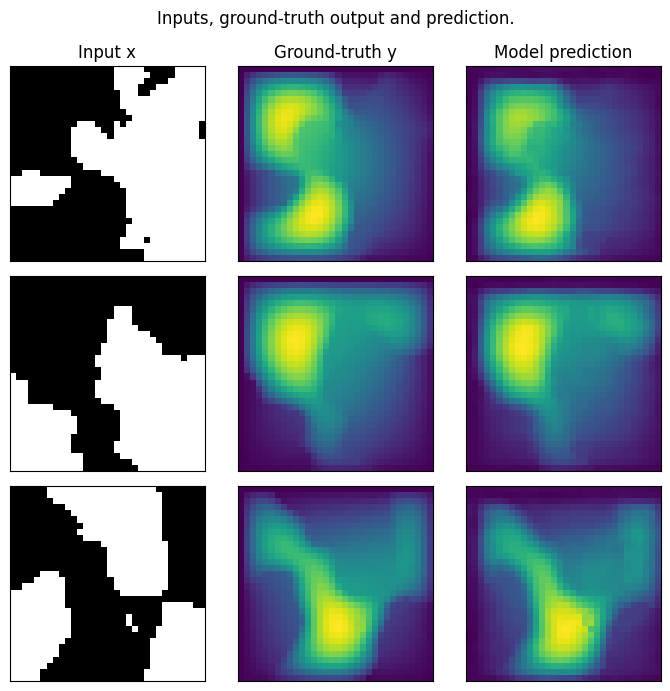

In [12]:

test_samples = test_loaders[32].dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0).cuda()).cpu()

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0:
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0:
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0:
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()


In [11]:
model.load_dict(paddle.load('model_trained.pdparams'))